In [38]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from itertools import permutations
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 9, 5

# Реалізація МНКО

До реалізації додано обрахування W - розширеної матриці нормальної системи рівнянь для повної моделі на початку роботи МНКО, і подальше її використання. Як наслідок, маємо більш оптимізований алгоритм, оскільки в ньому тепер замість зайвих операцій над частинами однієї й тієї ж матриці відбувається звернення до частин матриці W.

In [39]:
def LSMB(X, y, W=None, s=None, started=True, sigma_estimation=None,
         verbose=False, deep_verbose=False, create_dataframe=False):
    assert X.ndim == 2 and X.shape[1] > 0
    m = X.shape[1]
    if started:
        W = np.hstack((X.T @ X, (X.T @ y).reshape(-1, 1)))
        started = False
    assert W.ndim == 2 and W.shape[0] == m
    if m > 1:
        if create_dataframe:
            w, H_inv, RSS, df = LSMB(X[:,:-1], y, W[:-1,:], s,
                                     started, sigma_estimation,
                                     verbose, deep_verbose, create_dataframe)
            if s and m > s:
                return w, H_inv, RSS, df
        else:
            w, H_inv, RSS = LSMB(X[:,:-1], y, W[:-1,:], s,
                                 started, sigma_estimation,
                                 verbose, deep_verbose, create_dataframe)
            if s and m > s:
                return w, H_inv, RSS 
        # w is of shape = [m-1, 1]; H_inv is of shape = [m-1, m-1]    
        h = W[:m-1,m-1].reshape(-1,1) # (X[:,:-1].T @ X[:,-1]).reshape(-1,1) # shape = [m-1, 1]
        eta = W[m-1,m-1] # X[:,-1].T @ X[:,-1] # shape = [1, 1]
        alpha = H_inv @ h # shape = [m-1, 1]
        beta = eta - h.T @ alpha # shape = [1, 1]
        beta_inv = 1 / beta # shape = [1, 1]
        gamma = W[m-1,-1] # X[:,-1].T @ y # shape = [1, 1]
        nu = beta_inv * (gamma - h.T @ w) # shape = [1, 1]
        w = np.vstack((w - nu * alpha, nu))  # shape = [m, 1]
        H_next_inv = np.vstack((np.hstack((H_inv + beta_inv * alpha @ alpha.T,
                                           (- beta_inv * alpha).reshape(-1, 1))),
                               np.hstack((-beta_inv * alpha.T, beta_inv))))
        RSS_next = (RSS - nu.flatten() ** 2 * beta.flatten())[0]

    else: # 1
        H_inv = np.array([[0]])
        eta = beta = W[0,0] # X[:,-1].T @ X[:,-1]
        beta_inv = 1 / beta
        alpha = h = np.array([0])
        gamma = W[0, -1] # X[:,-1].T @ y
        nu = np.array([beta_inv * gamma])
        w = np.array([nu])
        H_next_inv = np.array(beta_inv).reshape(1, 1)
        RSS_next = (y.T @ y - W[0, -1:] @ w)[0] # y.T @ X[:,-1].reshape(-1, 1) @ w)[0]
        if create_dataframe:
            if sigma_estimation is None:
                df = pd.DataFrame(columns=['s', 'RSS', 'Cp', 'FPE', 'theta'])
            else:
                df = pd.DataFrame(columns=['s', 'RSS', 'Cp_simple',
                                           'Cp', 'FPE', 'theta'])
        
    if verbose:
        print('===============================================')
        print('\tStep {}'.format(m))
        print('===============================================')
        if deep_verbose:
            print('h_{}:\t\t{}'.format(m, h.reshape(-1,1)[:,0]))
            print('eta_{}:\t\t{}'.format(m, eta))
            print('alpha_{}:\t{}'.format(m, alpha.reshape(-1,1)[:,0]))
            print('beta_{}:\t\t{}'.format(m, beta))
            print('gamma_{}:\t{}'.format(m, gamma))
            print('nu_{}:\t\t{}'.format(m, nu))
            print('===============================================')
        print('> θ_{}: {}'.format(m, w[:, 0]))
        print('> H_{}_inv:\n{}'.format(m, H_next_inv))
        print('> RSS_{}: {}'.format(m, RSS_next))
    if create_dataframe:
        n = y.shape[0]
        FPE = (n + m) / (n - m) * RSS_next
        Cp_simple = RSS_next + 2 * m
        if sigma_estimation is None:
            df = df.append({'s': m, 'RSS': RSS_next,
                            'Cp': Cp_simple, 'FPE': FPE,
                            'theta': w[:, 0]},
                           ignore_index=True)
        else:
            Cp = RSS_next + 2 * sigma_estimation * m
            df = df.append({'s': m, 'RSS': RSS_next,
                            'Cp_simple': Cp_simple,
                            'Cp': Cp, 'FPE': FPE,
                            'theta': w[:, 0]},
                           ignore_index=True)
        return w, H_next_inv, RSS_next, df
    return w, H_next_inv, RSS_next

# Пошук моделі оптимальної складності

Метою роботи є пошук моделі оптимальної складності, причому наперед не відомо, яку саме підмножину всіх регресорів/аргументів містить така модель. Тому необхідно сконструювати і перевірити алгоритми для її пошуку.

In [74]:
class ModelConfig():
    m = 5
    n = 10
    n_grid = [10, 30, 100]
    theta = np.array([3, -2, 1, 0, 0])
    a = 0
    b = 2
    sigma = 0.3
    s0 = 3
    s = m
    
    def __init__(self, m=None, s0=None, theta=None, a=None, b=None,
                 X=None, y=None):
        if m:
            self.m = m
            self.s = m
        if s0:
            self.s0 = s0
        if theta:
            if isinstance(theta, dict) and theta['random']:
                self.theta = np.zeros(self.m)
                self.theta[:self.s0] = np.random.uniform(*theta['random'],
                                                         size=self.s0)
            elif theta == 'unknown':
                assert X is not None, 'Please provide data (X)'
                assert y is not None, 'Please provide target values as well (y)'
                self.theta = theta
            else:
                self.theta = theta
        if a:
            self.a = a
        if b:
            self.b = b
        if X is not None:
            assert y is not None, 'Please provide target values as well (y)'
            self.X = np.array(X)
            self.y = np.array(y)
            (self.n, self.m) = X.shape
            self.s = self.m
        else:
            self.compile()
        
    def generate_noise_and_output(self):
        self.ksi = np.random.normal(0, self.sigma, size=self.n)
        self.y = self.X @ self.theta + self.ksi
        
    def compile(self, n=None, sigma=None):
        if n:
            self.n = n
        if sigma:
            self.sigma = sigma
        self.X = np.random.uniform(self.a, self.b, size=(self.n, self.m))
        self.generate_noise_and_output()
        
    def show(self, n_limit=10):
        print('Regressors: m = {}'.format(self.m))
        print('True parameters: θ = {}'.format(self.theta))
        if not isinstance(self.theta, str):
            equation_str = ''
            for i, theta_i in enumerate(self.theta):
                equation_str += ' + ({}) * x{}'.format(theta_i, i+1)
            equation_str = 'y0 = '+ equation_str[3:]
            print(equation_str)
            print('Noise generation: σ = {}'.format(self.sigma))
        print('Sample length: n = {}'.format(self.n))
        print('X[:10]:\n{}'.format(self.X[:n_limit]))
        print('y[:10]:\n{}'.format(self.y[:n_limit]))
        
    def show_estimations(self):
        print('RSS(m) = {:5.5}'.format(self.RSS))
        print('σ* = {:5.5}'.format(self.sigma_hat ** .2))
    
    def estimate_sigma(self):
        _, _, self.RSS = RMNK(self.X, self.y, s=self.s,
                         verbose=False, create_dataframe=False)
        self.sigma_hat = self.RSS ** 2 / (self.X.shape[0] - self.X.shape[1])
        
    def run_grid_LSMB_model_selection(self):
        self.estimate_sigma()
        for i, n in enumerate(self.n_grid): 
            for j, sigma in enumerate(self.sigma_grid):
                self.compile(n, sigma)
                print('--------------------------------------------------------------')
                print('\t\t\tSAMPLE #{}'.format(i * len(self.n_grid) + j + 1))
                print('--------------------------------------------------------------')
                print('\t\tCONFUGURATIONS & DATA')
                self.show()
                print('\n\t\tRLSM ITERATIONS')
                theta_pred, _, _, df = LSMB(self.X, self.y, s=self.s,
                                            verbose=True,
                                            create_dataframe=True)
                print('\n\t\t\tRESULTS')
                print('\nPARAMETERS')
                print('True values:\tθ: {}'.format(self.theta))
                print('Estimates:\tθ*: {}'.format(theta_pred[:,0]))
                plt.plot(df['s'], df['RSS'], label='RSS')
                plt.plot(df['s'], df['Cp'], label='Cp')
                plt.plot(df['s'], df['FPE'], label='FPE')
                plt.legend()
                plt.show()
                print(df)
                print('s* by Cp:  {}'.format(np.array(df['Cp']).argmin()+1))
                print('s* by FPE: {}'.format(np.array(df['FPE']).argmin()+1))
                print()
    
    def run_single_LSMB_model_selection(self, p=None, plot=False, 
                                        criteria=['Cp', 'FPE', 'RSS']):
        """Single LSMB
        
        p : list or str
            if list: permutation indices
            if str: one of 'direct', 'reverse', 'correlation'
                    defines how to create permutation
        """
        if p == 'reverse':
            print('=============\nREVERSE\n=============')
            p = np.flip(np.arange(self.m), axis=0)
        elif p == 'correlation':
            print('=====================\nCORRELATION INCLUDING\n=====================')
            correlations = np.abs(np.cov(self.X.T, self.y.T)[-1,:-1])
            p = np.argsort(-correlations)
            print('Correlations with target:\n\t{}'.format(correlations))
        elif isinstance(p, list):
            print('=============\nCUSTOM\n=============')
        else:
            print('=============\nDIRECT\n=============')
            p = np.arange(self.m)
        print('Regressors order:\n\t{}'.format(p+1))
        theta_pred, _, _, df = LSMB(self.X[:,p], self.y, s=self.s,
                                    verbose=False, create_dataframe=True)
            
        df['regressors'] = [str(sorted(p[:int(s)]+1)) for s in df.s]
        for criterion in criteria:
            df[criterion] = np.round(df[criterion], 6)
        if plot:
            for criterion in criteria:
                plt.plot(df['s'], df[criterion], label=criterion)
                plt.legend()
            plt.show()
        df = df.sort_values(by=criteria).reset_index()\
                   [['s', 'regressors', 'theta'] + criteria]
        self.s_opt, self.regressors_opt, \
        self.theta_opt = df.loc[0, ['s', 'regressors', 'theta']]
        self.theta_opt = np.hstack((self.theta_opt,
                         np.zeros(self.m -
                                  len(self.theta_opt))))[np.argsort(p)]
        print('Optimal:')
        print('\ts* = {}'.format(self.s_opt))
        print('\tregressors = {}'.format(self.regressors_opt))
        print('\ttheta* = {}'.format(self.theta_opt))
        print('Cp* {}'.format(df.loc[0, 'Cp']))
        return df
    
    def run_single_full_LSMB_model_selection(self,
                                             criteria=['Cp', 'FPE', 'RSS']):
        print('=============\nBRUT FORCE\n=============')
        total_df = pd.DataFrame()
        for p in permutations(range(self.m)):
            p = np.array(p)
            theta_pred, _, _, df = LSMB(self.X[:,p], self.y, s=self.s,
                                        verbose=False, create_dataframe=True)
            df = df.drop(columns=['theta'])
            df['regressors'] = [str(sorted(p[:int(s)]+1)) for s in df.s]
            total_df = pd.concat([total_df, df], axis=0)
        for criterion in criteria:
            total_df[criterion] = np.round(total_df[criterion], 6)
        total_df = total_df.drop_duplicates()
        total_df = total_df.sort_values(by=criteria).reset_index()\
                   [['s', 'regressors'] + criteria]
        return total_df
    
    def run_single_random_LSMB_model_selection(self, K=20,
                                               criteria=['Cp', 'FPE', 'RSS'],
                                               main_criterion='Cp'):
        print('================================\nRANDOM INCLUDING WITH K = {}\n================================'.format(K))
        permutations = [np.random.permutation(self.m) for k in range(K)]
        total_df = pd.DataFrame()
        best_df = pd.DataFrame()
        self.main_criterion_value = np.Inf
        for p in permutations:
            p = np.array(p)
            theta_pred, _, _, df = LSMB(self.X[:,p], self.y, s=self.s,
                                        verbose=False, create_dataframe=True)
            df = df.drop(columns=['theta'])
            df['regressors'] = [str(sorted(p[:int(s)]+1)) for s in df.s]
            df = df.sort_values(by=criteria).reset_index()
            main_criterion_value = df.loc[0, main_criterion]
            if main_criterion_value < self.main_criterion_value:
                self.main_criterion_value = main_criterion_value
                self.theta_pred = theta_pred
                self.s_opt, self.regressors_opt = df.loc[0,
                                                         ['s', 'regressors']]
            total_df = pd.concat([total_df, df], axis=0)
            best_df = pd.concat([best_df, df.loc[0:0]], axis=0)
        for criterion in criteria:
            total_df[criterion] = np.round(total_df[criterion], 6)
            best_df[criterion] = np.round(best_df[criterion], 6)
        total_df = total_df.drop_duplicates()
        total_df = total_df.sort_values(by=criteria).reset_index()\
                   [['s', 'regressors'] + criteria]
        best_df = best_df.rename(columns={'s': 's*',
                                 'regressors': 'regressors*'}).reset_index()\
                  [['s*', 'regressors*'] + criteria]
        print()
        print(best_df[:5])
        print('...')
        print(best_df[-5:])
        print()
        print('Optimal:')
        print('\ts* = {}\n\tregressors = {}'.format(self.s_opt,
                                                    self.regressors_opt))
        print('Cp* {}'.format(best_df.loc[0, 'Cp']))
        return total_df, best_df
    
    def run_single_picking_LSMB_model_selection(self,
                                               criteria=['Cp', 'FPE', 'RSS'],
                                               main_criterion='Cp'):
        print('================================\nPICKING INCLUDING\n================================'.format(K))
        total_df = pd.DataFrame()
        best_df = pd.DataFrame()
        self.main_criterion_value = np.Inf
        remained_indices = list(range(self.m))
        regressors_indices = []
        while len(remained_indices) > 0:
            local_main_criterion_value = np.Inf
            for i in remained_indices:
                p = np.array(regressors_indices + [i])
                theta_pred, _, _, df = LSMB(self.X[:,p], self.y, s=len(p),
                                            verbose=False,
                                            create_dataframe=True)
                df = df.drop(columns=['theta'])
                df['regressors'] = [str(sorted(p[:int(s)]+1)) for s in df.s]
                df = df.sort_values(by=criteria).reset_index()
                main_criterion_value = df.loc[0, main_criterion]
                if main_criterion_value < local_main_criterion_value:
                    local_main_criterion_value = main_criterion_value
                    local_df = df[:1]
                    local_i = i
                if main_criterion_value < self.main_criterion_value:
                    self.main_criterion_value = main_criterion_value
                    self.theta_pred = theta_pred
                    self.s_opt, \
                    self.regressors_opt = df.loc[0, ['s', 'regressors']]
                total_df = pd.concat([total_df, df], axis=0)
            regressors_indices += [local_i]
            remained_indices.remove(local_i)
            best_df = pd.concat([best_df, local_df], axis=0)
        for criterion in criteria:
            total_df[criterion] = np.round(total_df[criterion], 6)
            best_df[criterion] = np.round(best_df[criterion], 6)
        total_df = total_df.drop_duplicates().reset_index()\
                   [['s', 'regressors'] + criteria]
#         total_df = total_df.sort_values(by=criteria).reset_index()\
#                    [['s', 'regressors'] + criteria]
        best_df = best_df.rename(columns={'s': 's*',
                                 'regressors': 'regressors*'}).reset_index()\
                  [['s*', 'regressors*'] + criteria]
        print('Optimal:')
        print('\ts* = {}\n\tregressors = {}'.format(self.s_opt,
                                                    self.regressors_opt))
        print('Cp* {}'.format(best_df.loc[0, 'Cp']))
        return total_df, best_df

## Задання конфігурацій. Створення вибірок

### Тест 1 (вибірка аналогічна вибірці з лабораторної роботи №2)

In [75]:
config1 = ModelConfig(a=0, b=0.5)
config1.compile(n=50, sigma=0.3)
config1.generate_noise_and_output()
config1.show()

Regressors: m = 5
True parameters: θ = [ 3 -2  1  0  0]
y0 = (3) * x1 + (-2) * x2 + (1) * x3 + (0) * x4 + (0) * x5
Noise generation: σ = 0.3
Sample length: n = 50
X[:10]:
[[0.46561448 0.13177678 0.48999606 0.30161547 0.2554724 ]
 [0.21450538 0.12275378 0.04897242 0.44082267 0.22493672]
 [0.07371444 0.22934098 0.07984592 0.04420905 0.28319288]
 [0.36677571 0.24252745 0.32184408 0.10646167 0.43246891]
 [0.33639061 0.16639864 0.48527742 0.28986672 0.47194386]
 [0.38376642 0.01181009 0.04508622 0.39663257 0.2363153 ]
 [0.2648668  0.47390601 0.33500476 0.30933447 0.22443074]
 [0.17904047 0.31283548 0.45190911 0.1860616  0.32581474]
 [0.13370161 0.24277384 0.14315102 0.44830338 0.08468108]
 [0.25076625 0.46252827 0.30611974 0.09209223 0.43906349]]
y[:10]:
[ 1.57603169  0.75305161 -0.25017284  0.59044411  0.98947763  1.2927249
 -0.10172334  0.30588597  0.11643434  0.31042567]


### Тест 2 (велика вибірка з великою кількістю регресорів)

In [76]:
config2 = ModelConfig(m=15, s0=10, a=0, b=0.5, theta={'random': [1, 10]})
config2.compile(n=100, sigma=0.3)
config2.generate_noise_and_output()
config2.show(5)

Regressors: m = 15
True parameters: θ = [1.25854225 7.40708766 3.61187174 3.33315902 2.93936557 8.88241441
 7.11291564 4.55185922 1.86890048 6.47614405 0.         0.
 0.         0.         0.        ]
y0 = (1.2585422473435313) * x1 + (7.407087658564949) * x2 + (3.61187174465614) * x3 + (3.3331590207599744) * x4 + (2.9393655703579973) * x5 + (8.882414407613279) * x6 + (7.1129156351388385) * x7 + (4.551859220405104) * x8 + (1.8689004785967571) * x9 + (6.476144048489866) * x10 + (0.0) * x11 + (0.0) * x12 + (0.0) * x13 + (0.0) * x14 + (0.0) * x15
Noise generation: σ = 0.3
Sample length: n = 100
X[:10]:
[[0.17520833 0.37849437 0.40064409 0.44122028 0.00364052 0.30418355
  0.2095684  0.13592204 0.07643344 0.12114588 0.40882558 0.21794862
  0.20281985 0.32575893 0.22380376]
 [0.36902697 0.08620885 0.09948783 0.0169672  0.19314441 0.12530054
  0.07987453 0.10244825 0.35207054 0.45918878 0.12039601 0.16136782
  0.22600775 0.43710915 0.27851729]
 [0.43353718 0.02243966 0.38327133 0.44194089 0.42

### Тест 3 (власні задачі)

#### Вміст октану

При дослідженні виробничого процесу нафтопереробному заводі вимірюється вміст октану в нафті залежно від кількості 3-х сировинних матеріалів та змінної, що характеризує умови виробництва. Вхідні змінні (5):

- кількість матеріалу 1
- кількість матеріалу 2
- кількість матеріалу 3
- кількісний показник умов виробництва
- одиниця, відповідає вільному члену

Вихідна змінна:
- вміст октану

In [77]:
dataframe_path = 'data/octane-rating.csv'
df = pd.read_csv(dataframe_path)
config3 = ModelConfig(theta='unknown',
                      X=df.loc[:, 'One':'Condition'],
                      y=df['Octane number'])
config3.show()

Regressors: m = 5
True parameters: θ = unknown
Sample length: n = 82
X[:10]:
[[ 1.      55.33     1.72    54.       1.66219]
 [ 1.      59.13     1.2     53.       1.58399]
 [ 1.      57.39     1.42    55.       1.61731]
 [ 1.      56.43     1.78    55.       1.66228]
 [ 1.      55.98     1.58    54.       1.63195]
 [ 1.      56.16     2.12    56.       1.68034]
 [ 1.      54.85     1.17    54.       1.58206]
 [ 1.      52.83     1.5     58.       1.54998]
 [ 1.      54.52     0.87    57.       1.5623 ]
 [ 1.      54.12     0.88    57.       1.57818]]
y[:10]:
[92.19 92.74 91.88 92.8  92.56 92.61 92.33 92.22 91.56 92.17]


#### Ціни на нерухомість

Вхідні змінні (36):

- Тип житла (номер)
- Дистанція від вулиці до фасаду в футах
- Розмір ділянки в квадратних футах
- Загальна якість матеріалів та обробки
- Загальний стан житла
- Рік початку будівництва
- Рік переробки
- Площа фанери в квадратних футах
- Площа підвалу 1 в квадратних футах
- Площа підвалу 2 в квадратних футах
- Площа підвалу (незробленого) в квадратних футах
- Загальна площа підвалу в квадратних футах
- Перший поверх, площа в квадратних футах
- Другий поверх, площа в квадратних футах
- Інші ділянки, площа в квадратних футах
- Житлова площа квадратних футів
- Підвал: кількість великих ванних кімнат
- Підвал: кількість маленьких ванних кімнат
- Вище рівня фундаменту: кількість великих ванних кімнат
- Вище рівня фундаменту: кількість маленьких ванних кімнат
- Кількість спалень вище рівня фундаменту
- Кількість кухонь вище рівня фундаменту
- Загальна кількість кімнат вище рівня фундаменту (не включає ванні кімнати)
- Кількість камінів
- Рік побудови гаража
- Розмір гаража відносно автомобіля
- Розмір гаража в квадратних футах
- Площа деревини в квадратних метрах
- площа відкритого веранди в квадратних футах
- Закрита площа під'їзду в квадратних футах
- три сезонних ганок площі в квадратних метрах
- площа екранної ганку в квадратних футах
- Площа басейну в квадратних футах
- Змішаний показник
- Місяць продажу (номер)
- Рік продажу

Вихідна змінна:
- Ціна на нерухомість в долларах

In [78]:
dataframe_path = 'data/house-prices-cleaned.csv'
df = pd.read_csv(dataframe_path)
config3 = ModelConfig(theta='unknown',
                      X=df.loc[:, 'MSSubClass':'YrSold'],
                      y=df['SalePrice'])
config3.show(1)

Regressors: m = 36
True parameters: θ = unknown
Sample length: n = 1460
X[:10]:
[[4.11087386e+00 4.18965474e+00 9.04204006e+00 7.00000000e+00
  5.00000000e+00 2.00300000e+03 2.00300000e+03 5.28320373e+00
  6.56103067e+00 0.00000000e+00 5.01727984e+00 6.75343792e+00
  6.75343792e+00 6.75110147e+00 0.00000000e+00 7.44483327e+00
  1.00000000e+00 0.00000000e+00 2.00000000e+00 1.00000000e+00
  3.00000000e+00 6.93147181e-01 8.00000000e+00 0.00000000e+00
  2.00300000e+03 2.00000000e+00 5.48000000e+02 0.00000000e+00
  4.12713439e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.00000000e+00 2.00800000e+03]]
y[:10]:
[12.24769912]


Далі в якості Теста 3 розглядатимемо саме ціни на нерухомість, оскільки ця задача є цікавішою. При захисті роботи продемонструємо дослідження також і для першої вибірки.

## Пошук моделі. Послідовне включення (метод з лабораторної роботи №2)

### Тест 1

DIRECT
Regressors order:
	[1 2 3 4 5]


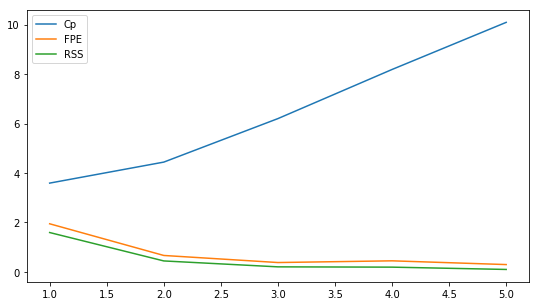

Optimal:
	s* = 1
	regressors = [1]
	theta* = [2.18307826 0.         0.         0.         0.        ]

REVERSE
Regressors order:
	[5 4 3 2 1]


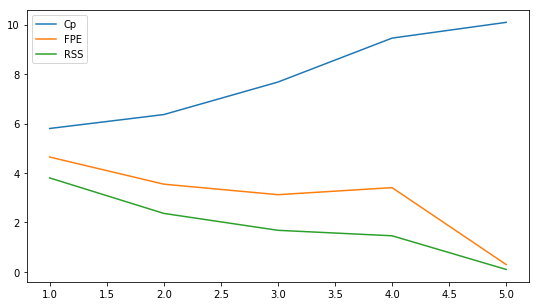

Optimal:
	s* = 1
	regressors = [5]
	theta* = [0.         0.         0.         0.         1.28848799]


In [52]:
df1 = config1.run_single_LSMB_model_selection(p=None,
                                       criteria=['Cp', 'FPE', 'RSS'],
                                       plot=True)
print()
df2 = config1.run_single_LSMB_model_selection(p='reverse',
                                       criteria=['Cp', 'FPE', 'RSS'],
                                       plot=True)

Як видно, при прямому порядку критерій $C_p$ має мінімум в точці $s=3$. А при зворотньому - в точці $s=5$. Алгоритм МНКО діє послідовно в порядку розташування регресорів, а в другому випадку найбільш впливові регресори були в як раз кінці. Тому перші, ті що не впливові, залишаються за критерієм, хоча, насправді, їх треба вилучити.

### Тест 2

DIRECT
Regressors order:
	[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


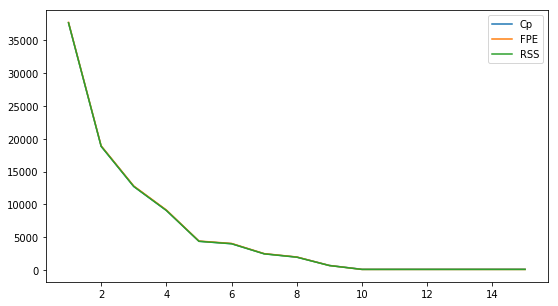

Optimal:
	s* = 10
	regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
	theta* = [5.79317639 5.1504336  2.41746608 3.97387742 9.71256043 1.25300617
 6.12154048 3.53966964 6.68098261 5.13294063 0.         0.
 0.         0.         0.        ]

REVERSE
Regressors order:
	[15 14 13 12 11 10  9  8  7  6  5  4  3  2  1]


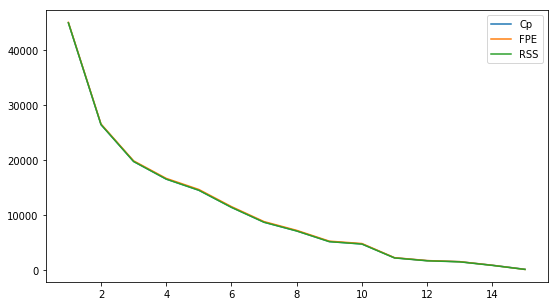

Optimal:
	s* = 15
	regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
	theta* = [ 5.77650485e+00  5.13826023e+00  2.41227600e+00  3.96700522e+00
  9.69077390e+00  1.25087856e+00  6.11609178e+00  3.52911147e+00
  6.66530328e+00  5.12276415e+00 -6.41751192e-02  1.98532581e-02
  7.73784910e-03  1.38733395e-01  4.99500159e-03]


In [53]:
df1 = config2.run_single_LSMB_model_selection(p=None,
                                       criteria=['Cp', 'FPE', 'RSS'],
                                       plot=True)
print()
df2 = config2.run_single_LSMB_model_selection(p='reverse',
                                       criteria=['Cp', 'FPE', 'RSS'],
                                       plot=True)

Ситуація дуже схожа на Тест 1: при прямому порядку критерій $C_p$ має мінімум в точці $s=10$. А при зворотньому - в точці $s=15$. Тут (в другому випадку) також найбільш впливові регресори в кінці, а невпливові на початку, і алгоритм пропонує враховувати всі регресори, що є не дуже добре.

### Тест 3

DIRECT
Regressors order:
	[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]


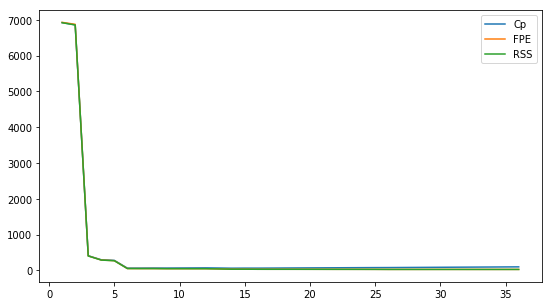

Optimal:
	s* = 14
	regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
	theta* = [-1.28216774e-02  1.35851253e-05  1.01151515e-01  1.25308956e-01
  4.12106912e-02  3.12536597e-03  3.92878638e-04 -4.94563644e-06
  1.29231644e-02 -2.45073557e-03 -3.51982786e-03  1.69078657e-02
  4.24867319e-01  3.14435771e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
Cp* 61.471062

REVERSE
Regressors order:
	[36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13
 12 11 10  9  8  7  6  5  4  3  2  1]


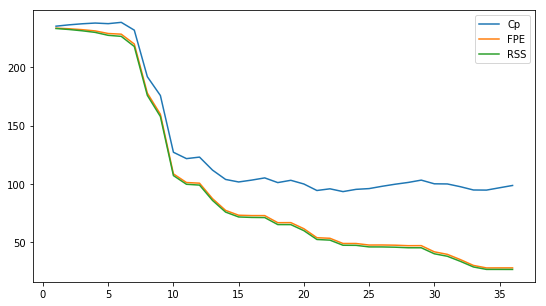

Optimal:
	s* = 23
	regressors = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
	theta* = [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.61098624e-02 -2.95063243e-02  6.48993849e-01
  9.19192746e-02  6.26520803e-02  1.20066421e-01  6.97063260e-02
 -4.17975867e-02 -7.73319356e-01  1.55498563e-02  3.57490733e-02
 -5.79498604e-07  9.78581656e-02  9.61967394e-05  9.14427971e-03
  1.01267236e-02 -8.23456848e-03  7.53719402e-03  7.69962763e-03
 -1.80806774e-02 -4.87035069e-03  1.07276179e-03  3.69006574e-03]
Cp* 93.40499


In [79]:
df1 = config3.run_single_LSMB_model_selection(p=None,
                                       criteria=['Cp', 'FPE', 'RSS'],
                                       plot=True)
print()
df2 = config3.run_single_LSMB_model_selection(p='reverse',
                                       criteria=['Cp', 'FPE', 'RSS'],
                                       plot=True)

При прямому порядку критерій $C_p$ має мінімум в точці $s=14$. А при зворотньому - в точці $s=23$. Виходить, результати алгоритмів перетинаються тільки в одному регресорі - №14. Це повинно бути спричиненим тим, що впливові регресори знаходиться як на початку, так і в середині, так і в кінці; а неінформативні розташовані серед них довільно.

## Пошук моделі. Метод кореляційного включення

### Тест 1

True parameters: [ 3 -2  1  0  0]
CORRELATION INCLUDING
Correlations with target:
	[0.06569745 0.03773802 0.04581767 0.00269637 0.01184363]
Regressors order:
	[1 3 2 5 4]


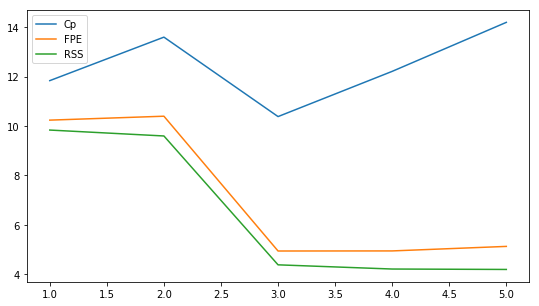

Optimal:
	s* = 3
	regressors = [1, 2, 3]
	theta* = [ 3.2472125  -1.8874175   0.45165918  0.          0.        ]


In [61]:
print('True parameters: {}'.format(config1.theta))
df1 = config1.run_single_LSMB_model_selection(p='correlation',
                                       criteria=['Cp', 'FPE', 'RSS'],
                                       plot=True)

Як видно, кореляції з вихідною величиною останніх двох регресорів на порядок менші за перших трьох, тому вони знаходяться в кінці, і критерій має мінімум в точці $s=3$, що означає - не враховувати ці два останні регресори, а це є якраз оптимально.

### Тест 2

True parameters: [4.78810646 2.95580706 7.65240587 4.4327905  5.570617   3.82038114
 5.94325222 3.10645092 1.99491128 6.23821647 0.         0.
 0.         0.         0.        ]
CORRELATION INCLUDING
Correlations with target:
	[0.09332291 0.08169343 0.17238183 0.05445205 0.13026669 0.13951467
 0.13054044 0.0510081  0.03267973 0.09638311 0.04102169 0.00896885
 0.0139145  0.01103658 0.05946645]
Regressors order:
	[ 3  6  7  5 10  1  2 15  4  8 11  9 13 14 12]


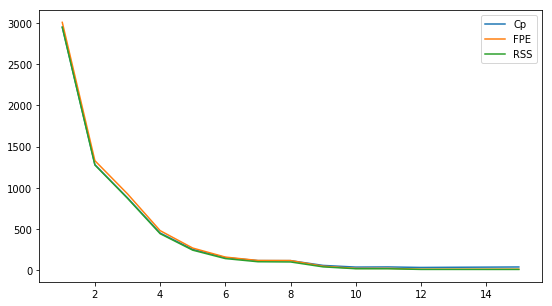

Optimal:
	s* = 12
	regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15]
	theta* = [ 5.12304282  2.96468995  7.59004491  4.34983703  5.67010341  3.73624294
  6.02620155  2.88748896  2.11548198  5.94424658  0.14518421  0.
  0.          0.         -0.1261242 ]


In [69]:
print('True parameters: {}'.format(config2.theta))
df1 = config2.run_single_LSMB_model_selection(p='correlation',
                                       criteria=['Cp', 'FPE', 'RSS'],
                                       plot=True)

Кореляції всіх неінформативних регресорів дуже малі - порядка -3, -4, що спричинене шумами. В результаті, розмістивши їх в кінці, критерій має мінімум в точці $s=10$, що якраз відповідає врахуванню тільки впливових регресорів.

### Тест 3

True parameters: unknown
CORRELATION INCLUDING
Correlations with target:
	[5.57596614e-03 4.96374698e+00 8.26491953e-02 4.51442989e-01
 1.63882816e-02 7.07669256e+00 4.66445015e+00 1.63966386e+00
 2.48714016e-01 2.23758820e-02 1.54214723e-01 1.70630669e-01
 7.72140589e-02 2.37815311e-01 1.62738556e-02 9.72242664e-02
 4.89641813e-02 3.17601408e-04 1.30886967e-01 6.30718701e-02
 6.81193001e-02 5.14465628e-03 3.46980247e-01 1.26038896e-01
 4.16687853e+01 2.03176351e-01 5.55885342e+01 3.55780446e-01
 3.95449211e-01 1.43006510e-01 1.56705081e-02 5.93336132e-02
 1.22572971e-02 3.28385950e-02 6.19136590e-02 1.97682209e-02]
Regressors order:
	[27 25  6  2  7  8  4 29 28 23  9 14 26 12 11 30 19 24 16  3 13 21 20 35
 32 17 34 10 36  5 15 31 33  1 22 18]


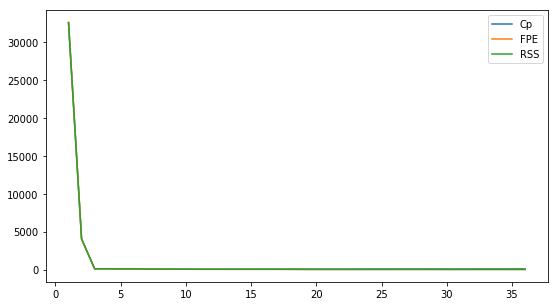

Optimal:
	s* = 11
	regressors = [2, 4, 6, 7, 8, 9, 23, 25, 27, 28, 29]
	theta* = [ 0.00000000e+00  6.16508069e-05  0.00000000e+00  1.17978290e-01
  0.00000000e+00  1.62350673e-03  3.69267563e-03 -3.26930295e-06
  2.14658894e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  6.47731113e-02  0.00000000e+00
  5.15876051e-05  0.00000000e+00  2.72399131e-04  5.69459418e-03
  5.16573136e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
Cp* 67.05855


In [80]:
print('True parameters: {}'.format(config3.theta))
df1 = config3.run_single_LSMB_model_selection(p='correlation',
                                       criteria=['Cp', 'FPE', 'RSS'],
                                       plot=True)

Інформації щодо істинного впливу регресорів на вихідну змінну в цій задачі ми не маємо, тому можемо робити 
висновки тільки на основі розроблених методів пошуку оптимальної складності. Даний алгоритм показує, що з вихідною величиною дуже корелюють два регресори, для яких значення кореляції мають порядок 1: це 27 і 25; чотири регресори мають кореляції порядка 0: це 6, 2, 7 і 8. Далі 12 регресорів, для яких кореляції порядка -1, і для інших ще менше. Розташувавши регресори відповідно до кореляцій і виконавши МНКО, маємо мінімум критерія в точці $s=11$, і, дійсно, алгоритм пропонує регресори як з початку (відносно розташування в оригінальній матриці Х), так і з кінця, тобто гіпотези, описані вище, підтверджуються.

## Пошук моделі. Метод випадкового включення

### Тест 1

In [64]:
Ks = [10, 20, 50, 100]
for K in Ks:
    config1.run_single_random_LSMB_model_selection(K=K, criteria=['Cp'],
                                                   main_criterion='Cp')

RANDOM INCLUDING WITH K = 10

  s*      regressors*         Cp
0  5  [1, 2, 3, 4, 5]  14.197121
1  1              [1]  11.838363
2  1              [1]  11.838363
3  5  [1, 2, 3, 4, 5]  14.197121
4  1              [1]  11.838363
...
  s*      regressors*         Cp
5  1              [1]  11.838363
6  5  [1, 2, 3, 4, 5]  14.197121
7  2           [1, 4]  13.413639
8  4     [1, 2, 3, 4]  12.312111
9  5  [1, 2, 3, 4, 5]  14.197121

Optimal:
	s* = 1
	regressors = [1]
RANDOM INCLUDING WITH K = 20

  s*      regressors*         Cp
0  2           [1, 3]  13.598750
1  1              [1]  11.838363
2  3        [1, 2, 5]  10.389269
3  2           [1, 2]   8.641279
4  5  [1, 2, 3, 4, 5]  14.197121
...
   s*      regressors*         Cp
15  5  [1, 2, 3, 4, 5]  14.197121
16  1              [1]  11.838363
17  5  [1, 2, 3, 4, 5]  14.197121
18  5  [1, 2, 3, 4, 5]  14.197121
19  2           [1, 5]  13.816207

Optimal:
	s* = 2
	regressors = [1, 2]
RANDOM INCLUDING WITH K = 50

  s*      regressors*        

При $K>=20$ маємо стабільно правильний вибір регресорів. А при меншій кількості випадкових формувань послідовностей метод все ще може враховувати неінформативні регресори. Тож робимо висновок, що $K\approx20$ буде достатньо для побудови правильної моделі.

### Тест 2

In [70]:
Ks = [50, 100, 200, 500]
for K in Ks:
    config2.run_single_random_LSMB_model_selection(K=K, criteria=['Cp'],
                                                   main_criterion='Cp')

RANDOM INCLUDING WITH K = 50

   s*                                        regressors*         Cp
0  15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  39.608872
1  15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  39.608872
2  13        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15]  35.630379
3  15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  39.608872
4  15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  39.608872
...
    s*                                        regressors*         Cp
45  14    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]  37.630849
46  15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  39.608872
47  15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  39.608872
48  14    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]  37.630849
49  15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  39.608872

Optimal:
	s* = 11
	regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
RANDOM INCLUDING WITH K = 100

   s*                                       

В даній задачі за результатами дослідження видно, що алгоритм працює дуже добре при досить великих $K>=200$. При меншій кількості випадкових формувань результат роботи менш стабільний (хоча і при великих К не завжди стабільно правильний вибір), і менш точний, хоча і набагато швидший. Тож $K\approx200$ буде достатньо.

### Тест 3

In [82]:
Ks = [10, 20, 50, 100, 300]
for K in Ks:
    config3.run_single_random_LSMB_model_selection(K=K, criteria=['Cp'],
                                                   main_criterion='Cp')

RANDOM INCLUDING WITH K = 10

   s*                                        regressors*         Cp
0  22  [1, 2, 3, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16,...  80.063623
1  11          [3, 4, 6, 11, 19, 22, 23, 26, 29, 32, 33]  69.408811
2  21  [5, 6, 7, 9, 11, 16, 18, 20, 22, 23, 24, 25, 2...  81.087762
3  16  [1, 3, 4, 5, 6, 10, 12, 14, 16, 20, 22, 23, 26...  62.543005
4  20  [1, 5, 6, 8, 9, 11, 12, 13, 14, 19, 21, 24, 25...  79.516810
...
   s*                                        regressors*         Cp
5  17  [1, 2, 4, 7, 10, 12, 14, 15, 16, 17, 26, 27, 2...  69.535024
6  21  [1, 2, 3, 4, 12, 13, 14, 17, 19, 20, 21, 22, 2...  78.340527
7  10              [3, 7, 9, 11, 16, 21, 22, 23, 26, 33]  67.517495
8  22  [2, 3, 4, 5, 6, 8, 9, 11, 12, 16, 17, 19, 20, ...  73.840074
9  24  [2, 3, 4, 7, 10, 11, 12, 13, 15, 17, 19, 20, 2...  81.869493

Optimal:
	s* = 16
	regressors = [1, 3, 4, 5, 6, 10, 12, 14, 16, 20, 22, 23, 26, 31, 34, 35]
Cp* 80.063623
RANDOM INCLUDING WITH K = 20

   s*        

KeyboardInterrupt: 

Для цієї задачі будемо аналізувати метод, порівнюючи його результати з результатами попереднього алгоритму. Видно, що алгоритм нестабільний, повертає різні комбінації регресорів. Оскільки в цій задачі маємо дуже багато регресорів (36), то припускаємо, що для побудови хорошої моделі потрібно виконати дуже багато випадкових генерувань послідовностей, наприклад $K\approx1000$. Враховуючи, що попередній метод повертає такий набір: [2, 4, 6, 7, 8, 9, 23, 25, 27, 28, 29], бачимо, що ці результати перетинаються приблизно наполовину. За цим методом завжди або часто вважаються впливовими регресори 4, 6, 7, 16, 17 - перші три мають велику кореляцію з вихідною величиною, а два останні - не дуже велику, проте їх точно потрібно включати в модель. Нестабільність роботи алгоритма також може бути спричинена маленьким розміром вибірки (відносно кількості регресорів) - приблизно 1000, чого скоріш за все недостатньо.

## Пошук моделі. Метод перебірного включення

### Тест 1

In [65]:
total_df, best_df = config1.run_single_picking_LSMB_model_selection(\
                                                criteria=['Cp'],
                                                main_criterion='Cp')

PICKING INCLUDING
Optimal:
	s* = 2
	regressors = [1, 2]


Таблиця, яка добре демонструє роботу алгоритма (порядок зберігається), наведена нижче:

In [66]:
total_df

,s,regressors,Cp
0,1,[1],11.838363
1,1,[2],31.696636
2,1,[3],17.627706
3,1,[4],24.543350
4,1,[5],23.158641
5,2,"[1, 2]",8.641279
6,2,"[1, 3]",13.598750
7,2,"[1, 4]",13.413639
8,2,"[1, 5]",13.816207
9,3,"[1, 2, 3]",10.383796


Таблиця, яка містить глобально кращий результат на кожній ітерації підвищення складності

In [67]:
best_df

,s*,regressors*,Cp
0,1,[1],11.838363
1,2,"[1, 2]",8.641279
2,2,"[1, 2]",8.641279
3,2,"[1, 2]",8.641279
4,2,"[1, 2]",8.641279


Отже, для даної задачі алгоритм спрацював добре, він повернув оптимальну модель.

### Тест 2

In [71]:
total_df, best_df = config2.run_single_picking_LSMB_model_selection(\
                                                criteria=['Cp'],
                                                main_criterion='Cp')

PICKING INCLUDING
Optimal:
	s* = 10
	regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Таблиця, яка добре демонструє роботу алгоритма (порядок зберігається), наведена нижче:

In [72]:
total_df

,s,regressors,Cp
0,1,[1],3036.991209
1,1,[2],2989.529472
2,1,[3],2950.319058
3,1,[4],3445.336634
4,1,[5],3231.460600
5,1,[6],3069.851791
6,1,[7],2895.641223
7,1,[8],3416.058372
8,1,[9],3601.744030
9,1,[10],2631.002570


Таблиця, яка містить глобально кращий результат на кожній ітерації підвищення складності

In [73]:
best_df

,s*,regressors*,Cp
0,1,[10],2631.002570
1,2,"[3, 10]",1170.886113
2,3,"[3, 6, 10]",599.885734
3,4,"[1, 3, 6, 10]",393.931531
4,5,"[1, 3, 5, 6, 10]",258.373785
5,6,"[1, 3, 5, 6, 7, 10]",153.440465
6,7,"[1, 3, 4, 5, 6, 7, 10]",88.583377
7,8,"[1, 2, 3, 4, 5, 6, 7, 10]",56.614584
8,9,"[1, 2, 3, 4, 5, 6, 7, 8, 10]",36.447985
9,10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",29.940783


Для даної задачі також алгоритм спрацював добре і повернув оптимальну модель. Час роботи алгоритма тут звісно більший за перший метод (кореляційного включення), проте менший за другий метод (випадкового включення) і при цьому повертає правильну структуру, тож в цьому плані є кращим.

### Тест 3

In [83]:
total_df, best_df = config3.run_single_picking_LSMB_model_selection(\
                                                criteria=['Cp'],
                                                main_criterion='Cp')

PICKING INCLUDING
Optimal:
	s* = 7
	regressors = [3, 4, 5, 6, 9, 16, 26]
Cp* 158.358196


Таблиця, яка добре демонструє роботу алгоритма (порядок зберігається), наведена нижче:

In [35]:
total_df

,s,regressors,Cp
0,1,[1],6922.622699
1,1,[2],171607.168945
2,1,[3],595.423285
3,1,[4],8072.403830
4,1,[5],8415.507144
5,1,[6],158.358196
6,1,[7],175.164569
7,1,[8],208501.298773
8,1,[9],69222.239836
9,1,[10],187787.682459


Таблиця, яка містить глобально кращий результат на кожній ітерації підвищення складності

In [36]:
best_df

,s*,regressors*,Cp
0,1,[6],158.358196
1,2,"[6, 16]",78.361004
2,3,"[4, 6, 16]",54.822413
3,4,"[3, 4, 6, 16]",49.481128
4,5,"[3, 4, 5, 6, 16]",47.128611
5,6,"[3, 4, 5, 6, 9, 16]",45.398392
6,7,"[3, 4, 5, 6, 9, 16, 26]",44.912894
7,7,"[3, 4, 5, 6, 9, 16, 26]",44.912894
8,7,"[3, 4, 5, 6, 9, 16, 26]",44.912894
9,7,"[3, 4, 5, 6, 9, 16, 26]",44.912894


Для цієї задачі алгоритм працює довго, (хоча знову не довше ніж другий метод випадкового включення) і повертає такий набір регресорів [3, 4, 5, 6, 9, 16, 26]. Багато з них (3, 4, 6, 16, 26) дійсно перетинаються з результатами попередніх методів.

Якщо об'єднати результати трьох методів для цієї задачі, то отримаємо такий набір регресорів і такі ваги для них:

In [37]:
regressors1 = {2, 4, 6, 7, 8, 9, 23, 25, 27, 28, 29}
regressors2 = {4, 5, 6, 16, 17, 27, 31}
regressors3 = {3, 4, 5, 6, 9, 16, 26}
total = list(a.union(b).union(c))

theta, _, RSS_next, df = LSMB(config3.X[:, total], config3.y,
                              verbose=False, create_dataframe=True)

print('{} regressors: {}'.format(len(total), total))
print('   with theta: {}'.format(theta.flatten()))

NameError: name 'a' is not defined

# Висновки

Досліджуючи три методи пошуку моделі оптимальної складності, ми з'ясували - якщо говорити про ефективність алгоритму в контексті правильної структури і швидкодії, то вона залежить від умов і задачі, великий вплив на неї мають розмірності вибірок (кількість екземплярів та кількість регресорів) та наявність шумів. Конкретно для наших трьох задач: Тест 1 є найпростішим з усіх, і всі алгоритми ефективно побудували модель; Тест 2 є більш великою задачею, і для нього найефективнішими виявилися метод кореляційного включення та метод перебірного включення (хоча останній трохи менше через трохи повільнішу роботу), а метод випадкового включення також працює добре, проте потребує великої кількості випадкових генерацій послідовностей; Тест 3 є реальною задачею, для нього невідомі істинні параметри моделі, але ефективність алгоритмів очевидна, оскільки з 36 регресорів ми зупинилися на 17ти найвпливовіших.